In [1]:
script_idea = """
Script intended to train 1 NN for each drumtype, this is the UPDATED version.
Before training the model, you have to preprocess the songs and the annotations 
After processing, everything is going to EXP_PIPE_DATA (path, see bellow)
"""
print(script_idea)


Script intended to train 1 NN for each drumtype, this is the UPDATED version.
Before training the model, you have to preprocess the songs and the annotations 
After processing, everything is going to EXP_PIPE_DATA (see bellow)



# Define libraries, paths and import data

In [6]:
# Which instrument you want to run the pipeline for; ie if target_label = "HH" -> create model for hihat. 
target_label = "HH"

In [7]:
# preprocess modules
import librosa
from librosa import display
import os,sys,re,pandas as pd,numpy as np
from scipy.io import wavfile
import math
from sympy import Interval
# viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
# torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torch.optim as optim
# other
import random
import logging
import glob
import warnings
from google.colab import drive
import sys

ROOT_DIR = "/content/drive"
#  Just use this if you are using google as a bucket
drive.mount(ROOT_DIR, force_remount=True)
# Don't forget to type My Drive before the whole path (in case you are using gdrive)
# In case you're not using gdrive; MUSIC_DIR should be your rootdir
MUSIC_DIR = os.path.join(ROOT_DIR,'My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums')
AUDIO_DIR = os.path.join(MUSIC_DIR,'audio','drum_only')
ANNOTATIONS_DIR = os.path.join(MUSIC_DIR,'annotations','class')
# where your preprocessed data is for train & test (for the preprocesing script see )
EXP_PIPE_DATA = os.path.join(MUSIC_DIR,"pipe005_multiplemodelsdata_corrected_over60")
EXP_PIPE_DATA_TRAIN = os.path.join(EXP_PIPE_DATA,"train")
EXP_PIPE_DATA_TEST = os.path.join(EXP_PIPE_DATA,"test")

Mounted at /content/drive


In [8]:
# download trainmodel_utils.py and import it 
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/tesis_esp')
import trainmodel_utils

In [9]:
# reproductibility
myseed = 1995
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

We will split the whole "trainingdata" into 3 splits (train, val, test) ;Do NOT confuse this test split with tthe testfolder, the later one are OutOfSample  songs, that were not seen during training. Test ratio was not seen during training but we changed  some experiments according to it.

In [10]:
#get filepaths
file_paths_txt_train = glob.glob(EXP_PIPE_DATA_TRAIN+"/*.txt")
file_paths_npy_train = glob.glob(EXP_PIPE_DATA_TRAIN+"/*.npy")
# we should this one in the evaluation script, not in this one
file_paths_txt_test = glob.glob(EXP_PIPE_DATA_TEST+"/*.txt")
file_paths_npy_test = glob.glob(EXP_PIPE_DATA_TEST+"/*.npy")
## ------------params ------------
train_ratio = 0.8
validation_ratio = 0.2 # you should use then after
# test_ratio = 0.0


In [12]:
logfile_path = os.path.join(EXP_PIPE_DATA,f'BinaryClassBCEnn_model_{target_label}_logfile.log')
logging.basicConfig(filename = logfile_path, format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%m/%d/%Y %I:%M:%S %p')
file_paths_txt_targeted,file_paths_npy_targeted = trainmodel_utils.filter_path_for_target_label(file_paths_txt_train,file_paths_npy_train,target_label)

# load all data in memory
labels_list,data_npy_list = trainmodel_utils.load_labels_and_data_from_npy(file_paths_npy_all = file_paths_npy_targeted)
data = trainmodel_utils.merge_numpy_data(data_npy_list) # X
labels = trainmodel_utils.merge_labels_data(labels_list) # y
assert data.shape[0] == len(labels)
print(f" Dataset is of {data.shape[0]} onsets, \n with a 33x9 (64-> window size, strides of 16 to a padded signal of len 128")
# x_train, x_val, x_test,y_train,y_val,y_test = trainmodel_utils.trainvaltest_split(data,labels,train_ratio,validation_ratio,test_ratio, myseed)
# remember: if none, then it will be stratified by y.
x_train, x_val, y_train, y_val = train_test_split(data,labels,test_size=validation_ratio,random_state=myseed, stratify = None)

User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Disco_class__HH.txt 
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Disco_class__HH.npy
User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Britpop_class__HH.txt 
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Britpop_class__HH.npy
User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/Music

In [13]:
print("Data shape is:",data.shape)
print("Unique labels are:",set(labels))

Data shape is: (3247, 513, 17)
Unique labels are: {'HH', 'OTHER'}


In [14]:
# come from this unique_labels = list(set(labels)) 
unique_labels = ['OTHER',target_label]
unique_labels_idx = [idx for idx in range(len(unique_labels))]
unique_labels

['OTHER', 'HH']

In [15]:
def map_labels2idx(label_list2map, unique_labels):
  "map labels from unique_labels to its respective index"
  mapped_labels = [unique_labels.index(label_idx) for label_idx in label_list2map]
  return mapped_labels
  
def map_idx2labels(mapped_labels,unique_labels=unique_labels):
  labels = list()
  for idx in range(len(mapped_labels)):
    mapped_lab = mapped_labels[idx]
    label_name = unique_labels[mapped_lab]
    labels.append(label_name)
  return labels

In [16]:
labels_indexes = map_labels2idx(labels, unique_labels)
nclasses = len(unique_labels_idx)

In [17]:
print(labels[:5],labels_indexes[:5])

['HH', 'HH', 'HH', 'HH', 'OTHER'] [1, 1, 1, 1, 0]


In [83]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(myseed)

class Dataset(torch.utils.data.Dataset):
  """
  Data loader for mini batch processing in pytorch
  Based on https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel 
  """
  def __init__(self, data_tensor, labels):
        'Initialization'
        self.labels = labels
        self.data_tensor = data_tensor

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = self.data_tensor[index] #torch.tensor of 65x17 
        y = self.labels[index]
        return X, y

In [84]:
y_train_to_idx = map_labels2idx(y_train, unique_labels)
data_tensor_train = torch.tensor(x_train, dtype=torch.float32)
N,H,W = data_tensor_train.shape
data_tensor_train = data_tensor_train.reshape(N,1,H,W)
print(f"train dataset shape: {data_tensor_train.shape}")

train dataset shape: torch.Size([2597, 1, 513, 17])


In [85]:
# validation
y_val_to_idx = map_labels2idx(y_val, unique_labels)
data_tensor_val = torch.tensor(x_val, dtype=torch.float32)
N,H,W = data_tensor_val.shape
data_tensor_val = data_tensor_val.reshape(N,1,H,W)
print(f"val ndataset shape: {data_tensor_val.shape}")

val ndataset shape: torch.Size([650, 1, 513, 17])


An example of how the data is mapped:

In [86]:
print(f"[INFO] Example of the mapping:\n  y_train -> {y_train[:5]} \n to y_train_to_idx -> {y_train_to_idx[:5]}")

[INFO] Example of the mapping:
  y_train -> ['OTHER', 'OTHER', 'HH', 'OTHER', 'HH'] 
 to y_train_to_idx -> [0, 0, 1, 0, 1]


Scale our data

In [87]:
scaling_method = "meanstd_normalize"

if scaling_method == "meanstd_normalize":
  train_mean, train_std = data_tensor_train.mean(), data_tensor_train.std()
  normalize_train_data = {"mean":train_mean, "std":train_std}
  meanstd_normalize = torchvision.transforms.Normalize(**normalize_train_data, inplace=False) 
  print(f"[INFO]] Applying {scaling_method} method")
  data_tensor_train_norm = meanstd_normalize(data_tensor_train)
  data_tensor_val_norm = meanstd_normalize(data_tensor_val)
elif scaling_method == "minmax_normalize":
  train_max,trainmin = data_tensor_train.max(),data_tensor_train.min()
  train_maxmin_diff  =train_max-trainmin
  minmax_normalize = torchvision.transforms.Normalize(mean = trainmin, std = train_maxmin_diff, inplace=False) 
  print(f"[INFO]] Applying {scaling_method} method ")
  data_tensor_train_norm = minmax_normalize(data_tensor_train)
  data_tensor_val_norm = minmax_normalize(data_tensor_val)
else:
  pass

[INFO]] Applying meanstd_normalize method


In [102]:
# CUDA for PyTorch ; try to control as much randomness as possible
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic=True
# 
# Parameters
dataloader_params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 2,
          'worker_init_fn':seed_worker,
          'generator': g}
max_epochs = 100

# Generators
training_set = Dataset(data_tensor_train_norm, y_train_to_idx)
training_generator = torch.utils.data.DataLoader(training_set, **dataloader_params)

validation_set  = Dataset(data_tensor_val_norm, y_val_to_idx)
validation_generator = torch.utils.data.DataLoader(validation_set, **dataloader_params)


An example of the features that will be used:

In [103]:
nexamples2show = 5
testiter = iter(training_set) #start the iterator
for i in range(nexamples2show):
  first_x,first_y = next(testiter)
  print(f"Observation nubmer {i} has labelidx:{first_y} and shape {first_x.shape}")
 

Observation nubmer 0 has labelidx:0 and shape torch.Size([1, 513, 17])
Observation nubmer 1 has labelidx:0 and shape torch.Size([1, 513, 17])
Observation nubmer 2 has labelidx:1 and shape torch.Size([1, 513, 17])
Observation nubmer 3 has labelidx:0 and shape torch.Size([1, 513, 17])
Observation nubmer 4 has labelidx:1 and shape torch.Size([1, 513, 17])


See if there is a huge unbalanced data set or not

In [104]:
pd.Series(y_train).value_counts(normalize=False)

OTHER    1370
HH       1227
dtype: int64

In [105]:
pd.Series(y_train).value_counts(normalize=True)

OTHER    0.527532
HH       0.472468
dtype: float64

In [106]:
pd.Series(y_val).value_counts(normalize=False)

OTHER    337
HH       313
dtype: int64

In [107]:
# for evaluating f1score etc
threshold = pd.Series(y_train).value_counts(normalize=True)[1]
# threshold = 0.5
threshold_torch = torch.tensor([threshold])
print(f"[INFO] Threshold for this model is {threshold_torch}")

[INFO] Threshold for this model is tensor([0.4725], dtype=torch.float64)


In [108]:
def evaluate_data_pytorch(data_generator:torch.utils.data.DataLoader,pytorch_net,sklearnmetric:str ='classification_report',prediction_threshold = threshold_torch) ->str:
  """
  Function for evaluating validation set using torch dataloader. 
  taken/based on https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
  data_generator -> must be pytorch generator 
  pytorch_net: -> pytorch neural network
  
  sklearnmetric: sklearn metric that requires y_true and y_pred ; could be classification_report or f1_score or other
  prediction_threshold: torch tensor 1d ; just torch.tensor([threshold]) where threshold is a float 
  """
  truelabels_val,predictedlabels_val = list(),list()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for i, data in enumerate(data_generator, 0):
          # get the inputs; data is a list of [inputs, labels]
          if not cuda:
            inputs, labels = data
          if cuda:
            inputs, labels = data[0].to(device), data[1].to(device)
          #print(inputs.shape)
          outputs = net(inputs)
          predicted = (outputs>=prediction_threshold).float()*1
          #print(predicted)
          #total += labels.size(0)
          truelabels_val.extend(labels.tolist())
          predictedlabels_val.extend(predicted.tolist())
          #correct += (predicted == labels).sum().item()
  df_val = pd.DataFrame({"truelabel":truelabels_val,"predicted":predictedlabels_val})
  if sklearnmetric == "classification_report":
    cr = classification_report(y_true=df_val["truelabel"].tolist(),y_pred=df_val["predicted"].tolist(), output_dict = True)
  elif sklearnmetric == "f1_score_weighted":
    cr = f1_score(y_true=df_val["truelabel"].tolist(),y_pred=df_val["predicted"].tolist(),average = 'weighted')
  else:
    raise ValueError("Please  sklearn metric mustbe classification_report or f1_score with avergage weighted")      
  return cr

# Define network architecture CNN

In [109]:
cuda = False


class Net(nn.Module):
    def __init__(self,nchannels,nclasses, unique_labels, meanstd_normalize, prediction_threshold):
        """
        unique_labels: list of labels to be mapped; example: ['OTHER','KD'] 
        meanstd_normalize:  output from torchvision.transforms.Normalize; for zscaling 
            o             the data
        prediction_threshold: float in (0,1) interval; if proba>threshold then
                      predicted class will be TARGET else other. 
        nclasses of the net; 2 in this case since we are applying binary classif
        """
        # start
        super().__init__()
        self.prediction_threshold = torch.tensor([prediction_threshold])
        # this is the normalizer to used in the predictor then
        self.meanstd_normalizer = torchvision.transforms.Normalize(**meanstd_normalize, inplace=False) 
        # remove it if you want to this is jsut for cleaner predictions (use labels instead of etc)
        self.unique_labels = unique_labels
        # other attributes
        self.nchannels = nchannels
        self.nclasses = nclasses
        self.conv1 = nn.Conv2d(self.nchannels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2000, 120)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(120, 84)
        #self.dropout2 = nn.Dropout(p=0.3, inplace=False)
        self.fc3 = nn.Linear(84, self.nclasses)
    def forward(self, x):
        # conv1 
        x = self.conv1(x)
        #print("Conv1:",x.shape)
        x =F.relu(x)
        x = self.pool(x)
        #print("Pool1:",x.shape)
        x = self.conv2(x)
        #print("Conv2:",x.shape)
        x = F.relu(x)
        x = self.pool(x)
        #print("Pool2:",x.shape)
        # flatten  all dims except the batch; 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("Flattened, except batch:",x.shape)
        x = self.fc1(x)
        x=F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.dropout2(x)
        # pass over fc3 omg
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    def map_idx2labels(self,mapped_labels,unique_labels):
      labels = list()
      for idx in range(len(mapped_labels)):
        mapped_lab = mapped_labels[idx]
        label_name = unique_labels[mapped_lab]
        labels.append(label_name)
      return labels

    def predict(self,x_batch):
      """
      Final prediction function
      params:
        x_batch -> np.array model dimensions data_lenx513x17 data
      return: mapped prediction (either target label or other)
      """
      #x_batch = x_test[:10].copy()
      #N = len(x_batch)
      data_tensor = torch.tensor(x_batch, dtype=torch.float32)
      N,H,W = data_tensor.shape
      print(N,H,W)
      data_tensor = data_tensor.reshape(N,1,H,W)
      # noramalize data
      data_tensor = self.meanstd_normalizer(data_tensor)
      #forward pass
      predictions = self.forward(data_tensor)
      if self.prediction_threshold is not None:
        predictions = (predictions>=self.prediction_threshold).float()*1
      predictions2labels = self.map_idx2labels(predictions,self.unique_labels)
      return predictions2labels



# Define a few net params

In [110]:
is_weighted = False
if is_weighted:
  counts_other = y_train.count("OTHER")
  counts_traindata = len(y_train)
  counts_target = counts_traindata- counts_other
  scale_weights_array = counts_other/counts_target
  # scale_weights_array = [counts_traindata/counts_target, counts_traindata/counts_other]
  weight_to_balance = torch.tensor(scale_weights_array)
else:
  # equal to torch.tensor([1,1])
  weight_to_balance = None
print(f"[INFO] Current weights to loss function {weight_to_balance}")

[INFO] Current weights to loss function None


In [124]:
net = Net(nchannels=1,nclasses=1, unique_labels=unique_labels, meanstd_normalize=normalize_train_data, prediction_threshold = threshold)
if cuda:
  net.to(device)

#--- START network params
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
n_epochs = 100 
# this is like bce but with a logit ; so no need to use a sigmoid layer
criterion = nn.BCELoss(weight = weight_to_balance)
# if it doesnt improve within  early_stopping_patience iterations
early_stopping_patience = 10
early_stopping_min_increase = 0.01 # early_stopping_min_increase percent
metric_to_monitor = "f1-score"
#--- END network params

# Start training the net with early stopping

In [125]:
metadata_results_list = list()
# for early stopping
early_stopping_counter = 0
epoch = 0
metric_to_monitor_val_best = 0.0001 # to avoid zero division

while (epoch<n_epochs) and  (early_stopping_counter<=early_stopping_patience):
  running_loss = 0.0
  # BATCH RUN
  for i, data in enumerate(training_generator, 0):
      # get the inputs; data is a list of [inputs, labels]
      if not cuda:
        inputs, labels = data
      if cuda:
        inputs, labels = data[0].to(device), data[1].to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      # this is for making the outputs and the labels shapes equal 
      labels = labels.unsqueeze(1).float()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # print statistics
      running_loss += loss.item()


  metric_to_monitor_train = evaluate_data_pytorch(training_generator,pytorch_net = net,sklearnmetric='classification_report')['1'][metric_to_monitor]
  metric_to_monitor_val = evaluate_data_pytorch(validation_generator,pytorch_net = net,sklearnmetric='classification_report')['1'][metric_to_monitor]


  # monitor early stopping ; increase in comparison with best
  metric_increase_epoch = metric_to_monitor_val/metric_to_monitor_val_best-1
  if metric_increase_epoch<early_stopping_min_increase:
    # increase counter if it doesnt increase enough
    early_stopping_counter += 1
  else: # reset counter
    early_stopping_counter = 0
  
  if metric_to_monitor_val>metric_to_monitor_val_best:
    metric_to_monitor_val_best = metric_to_monitor_val
  # save results
  results_dict = dict()
  results_dict[f"epoch"] = epoch
  results_dict[f"{metric_to_monitor}_train"] = metric_to_monitor_train
  results_dict[f"{metric_to_monitor}_val"] = metric_to_monitor_val
  metadata_results_list.append(results_dict)

  print(f"[INFO] Epoch number: {epoch}, iterations with less than {early_stopping_min_increase} \
  improvement:{early_stopping_counter}; improvement_percentage (in comparison with best epoch): {metric_increase_epoch}")
  print(f"[INFO] {metric_to_monitor} train: {metric_to_monitor_train} and val: {metric_to_monitor_val}  ")
  epoch+=1
print(f'[INFO] Finished Training in {epoch} epochs')

[INFO] Epoch number: 0, iterations with less than 0.01   improvement:0; improvement_percentage (in comparison with best epoch): 5741.574257425743
[INFO] f1-score train: 0.6116700201207242 and val: 0.5742574257425743  
[INFO] Epoch number: 1, iterations with less than 0.01   improvement:0; improvement_percentage (in comparison with best epoch): 0.08461496951054981
[INFO] f1-score train: 0.6438095238095238 and val: 0.622848200312989  
[INFO] Epoch number: 2, iterations with less than 0.01   improvement:0; improvement_percentage (in comparison with best epoch): 0.12573865446248078
[INFO] f1-score train: 0.695906432748538 and val: 0.701164294954722  
[INFO] Epoch number: 3, iterations with less than 0.01   improvement:1; improvement_percentage (in comparison with best epoch): -0.018615333006476997
[INFO] f1-score train: 0.691959624086321 and val: 0.6881118881118882  
[INFO] Epoch number: 4, iterations with less than 0.01   improvement:0; improvement_percentage (in comparison with best epoc

# Analyze results over the net

In [126]:
df_results = pd.DataFrame(metadata_results_list)
df_results_train = df_results[["epoch","f1-score_train"]].copy().rename(columns={"f1-score_train":"f1-score"})
df_results_train["dataset_type"] = "training"
df_results_val = df_results[["epoch","f1-score_val"]].copy().rename(columns={"f1-score_val":"f1-score"})
df_results_val["dataset_type"] = "validation"
df_trainval = pd.concat([df_results_train,df_results_val],axis=0).reset_index(drop=True)
fig = px.line(df_trainval, x="epoch", y="f1-score", color='dataset_type')
fig.show()

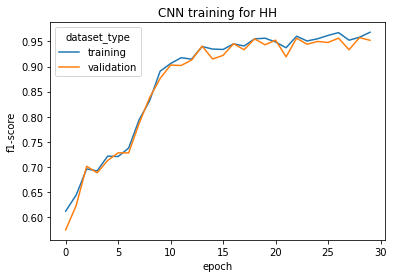

In [127]:
figpath2save = os.path.join(EXP_PIPE_DATA,f"BinaryClassBCE_nn_fig_model_{target_label}.jpeg")
sns_plot = sns.lineplot(x = df_trainval["epoch"], y = df_trainval["f1-score"] , hue = df_trainval["dataset_type"])
sns_plot.set( title = f"CNN training for {target_label}")
fig = sns_plot.get_figure()
fig.savefig(figpath2save)
fig.show()

# Save model and perform some checks

In [128]:
modelpath2save = os.path.join(EXP_PIPE_DATA,f"BinaryClassBCEnn_model_{target_label}.pth")
# os.remove(modelpath2save)
if os.path.exists(modelpath2save):
  print(f"[INFO] Model already exist on this path {modelpath2save}")
else:
  print(f"[INFO] Model saved on this path {modelpath2save}")
  torch.save(net,modelpath2save)

[INFO] Model saved on this path /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/BinaryClassBCEnn_model_HH.pth


In [120]:
loaded_net = torch.load(modelpath2save)


In [121]:
# important attributes
loaded_net.prediction_threshold
loaded_net.meanstd_normalizer
loaded_net.unique_labels

['OTHER', 'HH']

In [122]:
# function for predicting with raw data not normalized but after stft and stuff is applied
loaded_net.predict

<bound method Net.predict of Net(
  (meanstd_normalizer): Normalize(mean=0.14862293004989624, std=1.0505046844482422)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2000, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)>

In [123]:
loaded_net.predict

<bound method Net.predict of Net(
  (meanstd_normalizer): Normalize(mean=0.14862293004989624, std=1.0505046844482422)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2000, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)>